In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/10708/

/content/drive/MyDrive/10708


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cp .kaggle/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/stock-market-data

 99% 1.02G/1.03G [00:09<00:00, 79.1MB/s]
100% 1.03G/1.03G [00:09<00:00, 121MB/s] 


In [ ]:
!unzip *.zip

# Group By Sector

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [10]:
df = pd.read_csv("sectors/all_industries.csv")

In [11]:
len(df)

7730

In [12]:
sectors = []
for group in df.groupby(['Sector']):
  sectors.append(group[0])
tickers = {}
for sector in sectors:
  tickers[sector] = set()

<ipython-input-12-f071859d71b8>:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group in df.groupby(['Sector']):


In [13]:
tickers

{'Basic Materials': set(),
 'Consumer Discretionary': set(),
 'Consumer Staples': set(),
 'Energy': set(),
 'Finance': set(),
 'Health Care': set(),
 'Industrials': set(),
 'Miscellaneous': set(),
 'Real Estate': set(),
 'Technology': set(),
 'Telecommunications': set(),
 'Utilities': set()}

In [ ]:
for row in df.iterrows():
  try:
    tickers[row[1]['Sector']].add(row[1]['Symbol'])
  except:
    print(row)

In [15]:
total = 0
for sector in tickers:
  print(sector, len(tickers[sector]))
  total += len(tickers[sector])
print(total)

Basic Materials 53
Consumer Discretionary 1079
Consumer Staples 148
Energy 203
Finance 1708
Health Care 1296
Industrials 912
Miscellaneous 39
Real Estate 298
Technology 862
Telecommunications 68
Utilities 174
6840


In [16]:
with open('sector_ticker_sets.pkl', 'wb') as f:
  pickle.dump(tickers, f)

In [24]:
import glob

files = glob.glob('stock_market_data/nasdaq/csv/*.csv')
len(files), files[0].split('/')[-1][:-4]
not_found = 0
tech = []

provided = {}
for filename in files:
  name = filename.split('/')[-1][:-4]
  found = False
  for sector in tickers:
    if name in tickers[sector]:
      found = True
      provided[sector] = provided.get(sector, 0) + 1
    if name in tickers["Technology"]:
      tech.append(name)
  if not found:
    not_found += 1
    # print(name)
print(not_found, len(files))
    

348 1564


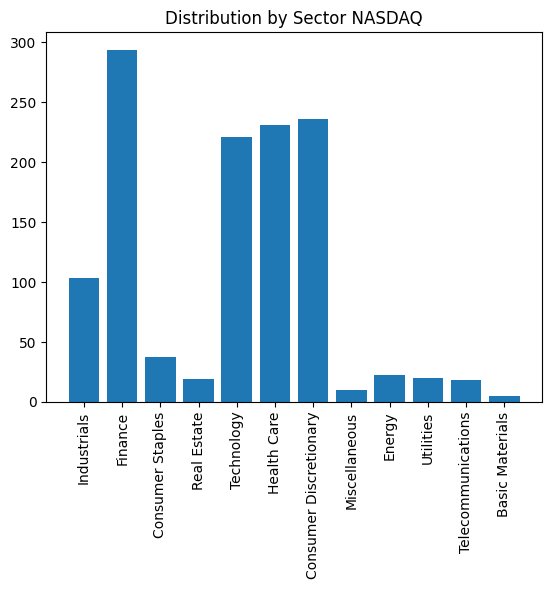

In [25]:
import matplotlib.pyplot as plt

D = provided

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation=90)
plt.title("Distribution by Sector NASDAQ")

plt.show()

In [28]:
import glob

files = glob.glob('stock_market_data/nyse/csv/*.csv')
len(files), files[0].split('/')[-1][:-4]
not_found = 0
tech = []

provided = {}
for filename in files:
  name = filename.split('/')[-1][:-4]
  found = False
  for sector in tickers:
    if name in tickers[sector]:
      found = True
      provided[sector] = provided.get(sector, 0) + 1
      break
    if name in tickers["Technology"]:
      tech.append(name)
  if not found:
    not_found += 1
    # print(name)
print(not_found, len(files))

204 1145


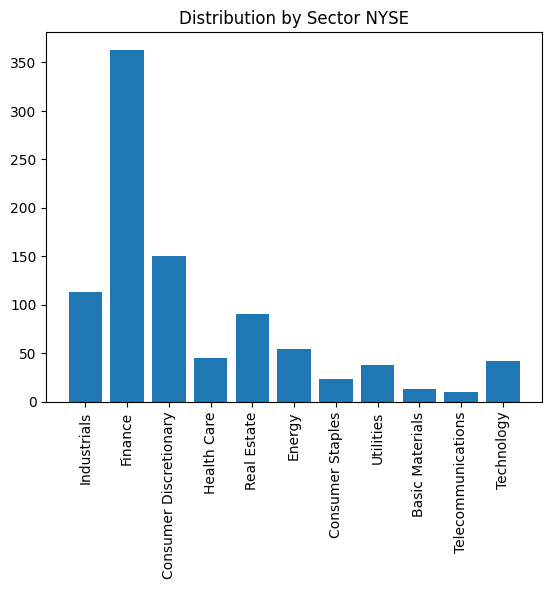

In [29]:
import matplotlib.pyplot as plt

D = provided

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation=90)
plt.title("Distribution by Sector NYSE")

plt.show()

In [19]:
provided

{'Industrials': 113,
 'Finance': 363,
 'Consumer Discretionary': 150,
 'Health Care': 45,
 'Real Estate': 90,
 'Energy': 54,
 'Consumer Staples': 23,
 'Utilities': 38,
 'Basic Materials': 13,
 'Telecommunications': 10,
 'Technology': 42}

In [30]:
tech = set(tech)
len(tech)

42

In [6]:
import pickle

# with open('tech_set_nyse.pkl', 'wb') as f:
#   pickle.dump(tech, f)
with open('tech_set_nyse.pkl', 'rb') as f:
  tech_nyse = pickle.load(f)
with open('tech_set.pkl', 'rb') as f:
  tech_nasdaq = pickle.load(f)

221
LRCX
Error tokenizing data. C error: Expected 7 fields in line 4926, saw 9
 None
torch.Size([8, 60]) torch.Size([8, 30])


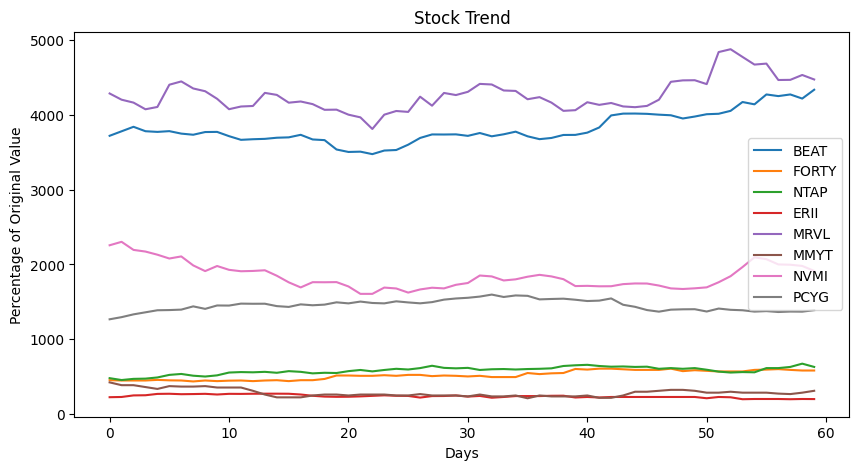

In [11]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
class CSVData(Dataset):
    def __init__(self, folder_path, tech, training_length, predict_length):
        self.folder_path = folder_path
        self.training_length = training_length
        self.predict_length = predict_length
        # self.files = [f for f in os.listdir(folder_path) if f.endswith('.csv')][:200]
        self.files = []
        for ticker in tech:
          self.files.append(ticker + '.csv')
        self.data = []
        self.tickers = []
        self.ticker_list = []
        print(len(self.files))

        for file in self.files:
          try:
            csv_file = pd.read_csv(os.path.join(folder_path, file))
            open_col = csv_file['Open'].values
            self.tickers.append(file.split('.')[0])
            ticker = file.split('.')[0]
            for i in range(len(open_col) - training_length - predict_length):
                self.data.append((open_col[i:i+training_length], open_col[i+training_length:i+training_length+predict_length], ticker))
          except Exception as e:
            print(e, print(file.split('.')[0]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        training_data, label_data, ticker = self.data[index]
        training_data = torch.Tensor(training_data)
        label_data = torch.Tensor(label_data)
        # ticker = torch.Tensor(ticker)
        return training_data, label_data, ticker

    def plot_trend(self, batch_data):
        plt.figure(figsize=(10, 5))
        for i in range(batch_data.size(0)):
            x = torch.arange(batch_data.shape[1])
            y = batch_data[i].numpy()  * 100
            plt.plot(x, y, label=f'{self.tickers[i]}')
        plt.xlabel('Days')
        plt.ylabel('Percentage of Original Value')
        plt.title('Stock Trend')
        plt.legend()
        plt.show()

# Example usage
folder_path = "stock_market_data/nasdaq/csv/"
training_length = 60
predict_length = 30

dataset = CSVData(folder_path, tech_nasdaq, training_length, predict_length)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate through batches of data
i = 0
for batch in dataloader:
    training_data, label_data, ticker = batch
    if i == 3:
      print(training_data.shape, label_data.shape)
      dataset.plot_trend(training_data)
      break
    i += 1
     

221
LRCX
Error tokenizing data. C error: Expected 7 fields in line 4926, saw 9
 None
torch.Size([8, 60]) torch.Size([8, 30])
['BEAT', 'FORTY', 'NTAP', 'ERII', 'MRVL', 'MMYT', 'NVMI', 'PCYG', 'S', 'LOGI', 'ITRN', 'CRNT', 'WB', 'ON', 'PERI', 'TCX', 'SCSC', 'IVAC', 'PERF', 'III', 'EEFT', 'CTG', 'SATS', 'CSGS', 'AWRE', 'SWKS', 'AZPN', 'AMSWA', 'DIOD', 'CEVA', 'AOSL', 'NVEC', 'CDNS', 'SANM', 'RMBS', 'AMD', 'TTMI', 'MSTR', 'DGLY', 'SLP', 'GTLS', 'SMTC', 'QCOM', 'SURG', 'GIGM', 'SPNS', 'HIMX', 'WDC', 'SGMA', 'CVV', 'MCHP', 'TTEC', 'ADI', 'SNCR', 'NATI', 'KLIC', 'EVLV', 'SOFO', 'KTCC', 'AXTI', 'REFR', 'SPLK', 'PXLW', 'FRSH', 'STEM', 'ELTK', 'VNET', 'EPAM', 'PCTY', 'TAIT', 'SLAB', 'ASUR', 'ACIW', 'PLAB', 'TTGT', 'AAOI', 'SILC', 'HCKT', 'NICE', 'EGHT', 'SYNA', 'ENPH', 'KOPN', 'VRNT', 'ADSK', 'MDRX', 'AMBA', 'NSSC', 'STRM', 'CRUS', 'INTC', 'KVHI', 'CLIR', 'YY', 'QLYS', 'CYBR', 'SSNC', 'VRNS', 'DJCO', 'DMRC', 'CAMT', 'TXN', 'ADBE', 'ARRY', 'AVID', 'DAVE', 'OLED', 'ZBRA', 'DGII', 'SEAC', 'MU', 'INO

<ipython-input-13-d7b8bdba2ca5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+list(tickers))
<ipython-input-13-d7b8bdba2ca5>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+list(tickers))


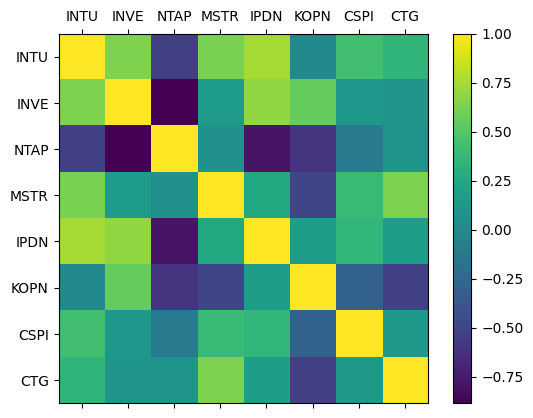

In [13]:
max_seq_len = 100
batch_size = 16

# Example usage
folder_path = "stock_market_data/nasdaq/csv/"
training_length = 60
predict_length = 30

dataset = CSVData(folder_path, tech_nasdaq, training_length, predict_length)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

import numpy as np

for data in train_loader:
    
    column_data, labels, tickers = data
    print(column_data.shape, labels.shape)
    # train_loader.plot_trend(column_data, column_len)
    corr_matrix = torch.corrcoef(column_data.squeeze(-1))

    # display correlation matrix
    # plt.matshow(corr_matrix, 0)
    print(dataset.tickers)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_matrix)
    fig.colorbar(cax)
    
    ax.set_xticklabels(['']+list(tickers))
    ax.set_yticklabels(['']+list(tickers))

    plt.show()
    break


In [14]:
# Define hyperparameters
batch_size = 8
learning_rate = 1e-20
hidden_size = 50
training_length = 60
predict_length = 30

train_folder_path = 'stock_market_data/nasdaq/csv/'
test_folder_path = 'stock_market_data/nyse/csv/'
train_dataset = CSVData(train_folder_path, tech_nasdaq, training_length, predict_length)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = CSVData(test_folder_path, tech_nyse, training_length, predict_length)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

221
LRCX
Error tokenizing data. C error: Expected 7 fields in line 4926, saw 9
 None
42


In [15]:
len(train_loader), len(test_loader)

(161214, 27645)

In [17]:
import pickle

with open('tech_loader.pkl', 'wb') as f:
  pickle.dump(test_loader, f)

In [19]:
with open('tech_loader.pkl', 'rb') as f:
  p = pickle.load( f)
len(p)

27645

In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Define the sequence length for input data to the LSTM model
sequence_length = 60
prediction_length = 30

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(seq_len, hidden_size)
        self.fc = nn.Linear(seq_len, prediction_length)
        self.fc1 = nn.Linear(seq_len, seq_len)
        self.fc2 = nn.Linear(seq_len, seq_len)

        self.fc_only_lstm = nn.Linear(hidden_size, prediction_length)
        self.gelu = nn.GELU()
        self.seq_len = seq_len

    def forward(self, x, adj_matrix):
        out, _ = self.lstm(x)
        # out2, _ = self.lstm2(out)
        # # out2 = out2.reshape(self.seq_len, -1)
        # tmp = torch.matmul(adj_matrix, out2)
        # # tmp = tmp.reshape(-1, self.seq_len)
        # tmp_out = self.fc1(tmp)
        # gelu1_out = self.gelu(tmp_out)

        # tmp = torch.matmul(adj_matrix, gelu1_out)
        # tmp_out = self.fc2(tmp)
        # gelu1_out = self.gelu(tmp_out)

        out = self.fc_only_lstm(out.reshape(x.shape[0], -1))
        return out


In [22]:
learning_rate = 1e-6
device = 'cuda'

model = StockLSTM(input_size=60, hidden_size=hidden_size, seq_len=training_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss().to(device)
overall_avg_loss = []
overall_test_loss = []

import numpy as np
import pandas as pd

def create_adj_matrix(data, threshold = 0.8):
    """
    Creates an adjacency matrix for a correlation graph given a pandas DataFrame of stock prices and a threshold value.

    :param data: pandas DataFrame of stock prices with each column representing a stock and each row representing a day
    :param threshold: minimum correlation coefficient value for an edge to be included in the graph
    :return: a numpy ndarray representing the adjacency matrix
    """
    # Calculate the correlation matrix
    # print(data.squeeze(-1))
    corr_matrix = torch.corrcoef(data.squeeze(-1))

    nan_indices = torch.isnan(corr_matrix)
    corr_matrix[nan_indices] = 0.0

    # adj_matrix = np.where(np.abs(corr_matrix) >= threshold, 1, 0)
    # return torch.from_numpy(adj_matrix).float()

    return corr_matrix

  

from tqdm import tqdm
num_epochs = 8

from sklearn.preprocessing import normalize
import numpy as np


def scale(X):
  '''
  Scales each row so that the largest value is 1.0
  '''
  eps = 1e-12
  scaled_X = (X - 0) / (torch.max(X, axis=1).values - 0 + eps).unsqueeze(1)
  return scaled_X, torch.max(X, axis=1).values.unsqueeze(1)

In [120]:


for epoch in range(num_epochs):
    print('epoch', epoch)
    running_loss = 0.0
    path = f'{epoch}_random_epoch_new.ckpt'
    torch.save(model.state_dict(), path)
    # Wrap the train_loader with tqdm for progress bar
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        column_data, labels, tickers = data
        optimizer.zero_grad()
        if torch.sum(torch.isnan(column_data)) + torch.sum(torch.isnan(labels))> 0:
          continue

        column_data, scaling_factor = scale(column_data)
        
        adj_matrix = create_adj_matrix(column_data)
        column_data = column_data.to(device)
        outputs = model(column_data, adj_matrix)

        labels = labels.to(device)
        outputs= outputs.to(device)

        labels_scaled = torch.clamp(labels / (scaling_factor.to(device) + 1e-12), 0.0, 1.0)
        loss = loss_fn(outputs, labels_scaled)
        # print(loss.item())

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10000 == 99 :
          print(running_loss / (i + 1))
        # Print the average loss every 100 batches
        # if i % 100 == 99:
        #     model.eval()
        #     test_loss = 0.0
        #     for test_data in test_loader:
        #         column_data_test, y_test = test_data
        #         optimizer.zero_grad()
        #         adj_matrix_test = create_adj_matrix(column_data_test)

        #         y_pred = model(column_data, adj_matrix_test)
        #         test_loss += loss_fn(y_pred, y_test)

        #     print(test_loss.item() / len(test_loader))
        #     overall_test_loss.append(test_loss.item() / len(test_loader))
        #     print(f"Epoch {epoch + 1}, Batch {i + 1}: Average Loss = {running_loss / 100}")
        #     overall_avg_loss.append(running_loss / 100)
        #     running_loss = 0.0
        #     model.train()
            
    # Print the average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average Loss = {avg_loss}")
    overall_avg_loss.append(avg_loss)

epoch 0


  0%|          | 131/134242 [00:00<12:25, 180.00it/s]

0.6816065460443497


  8%|▊         | 10194/134242 [00:23<04:09, 497.27it/s]

0.5347691253034195


 15%|█▌        | 20167/134242 [00:45<03:57, 479.93it/s]

0.3886933349940314


 22%|██▏       | 30145/134242 [01:07<04:26, 391.10it/s]

0.2894200606308754


 30%|██▉       | 40180/134242 [01:29<03:02, 514.19it/s]

0.2279309510836782


 37%|███▋      | 50172/134242 [01:51<03:00, 466.92it/s]

0.18862768870135657


 45%|████▍     | 60150/134242 [02:13<02:32, 487.29it/s]

0.16151755678028523


 52%|█████▏    | 70159/134242 [02:35<02:13, 479.06it/s]

0.14152003449306141


 60%|█████▉    | 80140/134242 [02:58<02:26, 370.50it/s]

0.12624243501991791


 75%|███████▍  | 100172/134242 [03:42<01:13, 460.75it/s]

0.10433058489837892


 82%|████████▏ | 110140/134242 [04:04<01:02, 385.52it/s]

0.09624748749285852


 90%|████████▉ | 120151/134242 [04:27<00:29, 469.79it/s]

0.08944231343025331


 97%|█████████▋| 130155/134242 [04:50<00:08, 476.84it/s]

0.0836699368181142


100%|██████████| 134242/134242 [04:58<00:00, 449.04it/s]


Epoch 1: Average Loss = 0.08151347806377575
epoch 1


  8%|▊         | 10154/134242 [00:23<04:29, 460.31it/s]

0.013423212487411934


 15%|█▌        | 20187/134242 [00:46<03:53, 487.99it/s]

0.0134688785924421


 22%|██▏       | 30180/134242 [01:07<03:35, 483.51it/s]

0.013250837581304901


 30%|██▉       | 40179/134242 [01:30<03:22, 463.37it/s]

0.013147105709373826


 37%|███▋      | 50142/134242 [01:53<03:55, 356.60it/s]

0.013018529905427336


 52%|█████▏    | 70173/134242 [02:38<02:12, 484.97it/s]

0.0127834826923665


 60%|█████▉    | 80167/134242 [03:00<02:29, 361.97it/s]

0.012695697108859176


 67%|██████▋   | 90170/134242 [03:22<01:31, 484.29it/s]

0.012583616445623762


 75%|███████▍  | 100146/134242 [03:45<01:13, 464.28it/s]

0.012498143031015308


 90%|████████▉ | 120168/134242 [04:29<00:30, 465.30it/s]

0.01230772865779421


 97%|█████████▋| 130164/134242 [04:52<00:08, 477.51it/s]

0.012213736359205571


100%|██████████| 134242/134242 [05:01<00:00, 445.80it/s]


Epoch 2: Average Loss = 0.01217820266918393
epoch 2


  8%|▊         | 10157/134242 [00:22<04:25, 467.73it/s]

0.011383320897538676


 15%|█▌        | 20159/134242 [00:45<04:24, 431.29it/s]

0.01119924113226809


 22%|██▏       | 30182/134242 [01:07<03:44, 463.61it/s]

0.011179878244302591


 30%|██▉       | 40147/134242 [01:29<03:19, 471.24it/s]

0.011103641756298136


 37%|███▋      | 50164/134242 [01:51<03:42, 378.02it/s]

0.011029921882924579


 45%|████▍     | 60185/134242 [02:13<02:31, 489.66it/s]

0.01100563121123062


 52%|█████▏    | 70171/134242 [02:36<02:20, 457.23it/s]

0.010958734412185851


 67%|██████▋   | 90166/134242 [03:20<01:31, 482.12it/s]

0.010887181661813366


 90%|████████▉ | 120174/134242 [04:26<00:28, 501.09it/s]

0.010826410983233453


 97%|█████████▋| 130155/134242 [04:48<00:10, 392.93it/s]

0.010801929531236062


100%|██████████| 134242/134242 [04:57<00:00, 451.04it/s]


Epoch 3: Average Loss = 0.010801982295575037
epoch 3


  8%|▊         | 10168/134242 [00:22<04:09, 496.52it/s]

0.010350062806219194


 15%|█▌        | 20155/134242 [00:44<04:18, 440.72it/s]

0.010435250923492186


 22%|██▏       | 30162/134242 [01:06<03:37, 477.67it/s]

0.010497352155066633


 30%|██▉       | 40139/134242 [01:28<04:17, 365.17it/s]

0.010435415840831973


 37%|███▋      | 50151/134242 [01:50<03:03, 459.12it/s]

0.010440139988053427


 45%|████▍     | 60174/134242 [02:12<02:29, 495.76it/s]

0.01041771657274069


 52%|█████▏    | 70145/134242 [02:34<02:45, 386.26it/s]

0.010411265918437143


 60%|█████▉    | 80180/134242 [02:56<01:50, 489.68it/s]

0.010415298938317389


 67%|██████▋   | 90166/134242 [03:18<01:28, 497.13it/s]

0.010399266712124756


 75%|███████▍  | 100140/134242 [03:40<01:28, 386.25it/s]

0.010401149160328338


 89%|████████▉ | 120145/134242 [04:23<00:29, 482.91it/s]

0.010363261849607525


 97%|█████████▋| 130162/134242 [04:45<00:11, 355.01it/s]

0.010346100293910135


100%|██████████| 134242/134242 [04:54<00:00, 456.56it/s]


Epoch 4: Average Loss = 0.010343168295577859
epoch 4


  8%|▊         | 10176/134242 [00:22<04:22, 472.47it/s]

0.010380815898245754


 15%|█▌        | 20195/134242 [00:45<04:00, 474.59it/s]

0.010260056109580012


 22%|██▏       | 30166/134242 [01:06<04:35, 378.09it/s]

0.01020199518859815


 30%|██▉       | 40172/134242 [01:28<03:10, 493.42it/s]

0.010155270860175964


 37%|███▋      | 50177/134242 [01:50<02:56, 476.46it/s]

0.01010750777274347


 45%|████▍     | 60161/134242 [02:12<03:15, 378.94it/s]

0.010102803918803048


 52%|█████▏    | 70172/134242 [02:34<02:12, 483.48it/s]

0.010108428024280832


 60%|█████▉    | 80190/134242 [02:56<01:47, 503.85it/s]

0.010100090462997405


 67%|██████▋   | 90175/134242 [03:18<01:30, 489.45it/s]

0.01009450435368127


 75%|███████▍  | 100180/134242 [03:39<01:10, 480.73it/s]

0.010091212763048413


 82%|████████▏ | 110161/134242 [04:01<00:49, 488.89it/s]

0.010084826824155685


 90%|████████▉ | 120159/134242 [04:23<00:27, 505.96it/s]

0.010091791199984535


 97%|█████████▋| 130165/134242 [04:44<00:08, 472.77it/s]

0.01008421975004565


100%|██████████| 134242/134242 [04:53<00:00, 457.16it/s]


Epoch 5: Average Loss = 0.010078884820064834
epoch 5


  0%|          | 177/134242 [00:00<04:53, 456.43it/s]

0.008340129940770567


  8%|▊         | 10179/134242 [00:22<04:18, 480.63it/s]

0.009804030972034992


 15%|█▌        | 20168/134242 [00:44<05:01, 377.98it/s]

0.009911472174461783


 22%|██▏       | 30179/134242 [01:05<03:25, 506.12it/s]

0.009928832124194294


 30%|██▉       | 40154/134242 [01:27<03:17, 477.17it/s]

0.00993690402198965


 37%|███▋      | 50182/134242 [01:49<02:59, 467.30it/s]

0.009924237952235819


 52%|█████▏    | 70157/134242 [02:33<02:14, 475.59it/s]

0.009932942577617305


 60%|█████▉    | 80186/134242 [02:55<01:54, 473.91it/s]

0.009911399921494625


 67%|██████▋   | 90179/134242 [03:16<01:27, 505.03it/s]

0.009894741783017415


 75%|███████▍  | 100172/134242 [03:38<01:10, 481.56it/s]

0.009888337724537427


 82%|████████▏ | 110171/134242 [04:00<00:48, 491.25it/s]

0.009896435346072147


 89%|████████▉ | 120141/134242 [04:21<00:40, 346.88it/s]

0.009911158236636288


 97%|█████████▋| 130166/134242 [04:43<00:08, 499.86it/s]

0.009908277289568323


100%|██████████| 134242/134242 [04:52<00:00, 458.54it/s]


Epoch 6: Average Loss = 0.009906423278280856
epoch 6


  0%|          | 164/134242 [00:00<05:09, 433.46it/s]

0.009437471139244735


  8%|▊         | 10151/134242 [00:22<05:26, 379.86it/s]

0.009917717380864121


 15%|█▌        | 20183/134242 [00:43<03:58, 478.06it/s]

0.010017023174791823


 22%|██▏       | 30194/134242 [01:05<03:40, 472.22it/s]

0.009907630310974786


 30%|██▉       | 40164/134242 [01:27<03:12, 487.88it/s]

0.009919141913758953


 37%|███▋      | 50164/134242 [01:48<02:56, 476.24it/s]

0.009874740541307768


 52%|█████▏    | 70174/134242 [02:32<02:09, 493.02it/s]

0.009858079831258389


 60%|█████▉    | 80140/134242 [02:54<02:09, 418.89it/s]

0.009865405995768062


 67%|██████▋   | 90152/134242 [03:15<01:28, 496.14it/s]

0.00985384010091503


 75%|███████▍  | 100164/134242 [03:37<01:08, 499.63it/s]

0.00984597559190659


 82%|████████▏ | 110169/134242 [03:58<01:05, 368.16it/s]

0.009837378370320784


 90%|████████▉ | 120154/134242 [04:20<00:28, 499.98it/s]

0.009828856831304434


 97%|█████████▋| 130176/134242 [04:42<00:08, 483.73it/s]

0.00982761145902613


100%|██████████| 134242/134242 [04:50<00:00, 461.89it/s]


Epoch 7: Average Loss = 0.009821767760902165
epoch 7


  0%|          | 151/134242 [00:00<06:44, 331.57it/s]

0.009617838347330689


  8%|▊         | 10156/134242 [00:22<04:26, 464.99it/s]

0.009823616250028538


 15%|█▌        | 20170/134242 [00:43<03:55, 485.17it/s]

0.009795277637877822


 22%|██▏       | 30135/134242 [01:05<04:46, 362.90it/s]

0.009822310809302454


 45%|████▍     | 60177/134242 [02:11<02:40, 461.05it/s]

0.009765085527848083


 52%|█████▏    | 70140/134242 [02:32<02:10, 490.05it/s]

0.009748608423612005


 60%|█████▉    | 80183/134242 [02:54<01:48, 500.51it/s]

0.009750446896756925


 67%|██████▋   | 90148/134242 [03:16<01:32, 477.42it/s]

0.00976990169801785


 75%|███████▍  | 100157/134242 [03:37<01:10, 484.75it/s]

0.009785834941650754


 82%|████████▏ | 110155/134242 [03:58<00:48, 494.67it/s]

0.009779437724543717


 90%|████████▉ | 120160/134242 [04:21<00:29, 474.84it/s]

0.009768485340219884


100%|██████████| 134242/134242 [04:51<00:00, 460.78it/s]

Epoch 8: Average Loss = 0.009768267498107172


In [88]:
# path = '3_epochs.ckpt'
# torch.save(model.state_dict(), path)
# model.load_state_dict(torch.load(path))

tech_model = StockLSTM(input_size=60, hidden_size=hidden_size, seq_len=training_length).to(device)
tech_model.load_state_dict(torch.load('3_epochs.ckpt'))
random_model = StockLSTM(input_size=60, hidden_size=hidden_size, seq_len=training_length).to(device)
random_model.load_state_dict(torch.load('7_random_epoch_new.ckpt'))



<All keys matched successfully>

In [53]:
with open('test_loader.pkl', 'rb') as f:
  random_test = pickle.load(f)
len(random_test)

188216

In [61]:
model = random_model
test_loss = 0.0
model.eval()
test_loader = random_test

test_loss = 0.0
with torch.no_grad():
  for i, test_data in tqdm(enumerate(test_loader), total=len(test_loader)):
      column_data_test, y_test, tickers = test_data
      column_data_test = column_data_test.to(device)
      y_test = y_test.to(device)
      column_data_test, scaling_factor = scale(column_data_test)
      if torch.sum(torch.isnan(column_data_test)) + torch.sum(torch.isnan(y_test))> 0:
          continue
      # optimizer.zero_grad()
      adj_matrix_test = create_adj_matrix(column_data_test)
      y_pred = model(column_data_test, adj_matrix_test) 
      y_test_clamp = torch.clamp(y_test / (scaling_factor.to(device) + 1e-12), 0.0, 1.0)

      loss = loss_fn(y_pred, y_test_clamp)
      test_loss += loss.item()
      if np.isnan(test_loss):
        print(column_data_test)
        print(y_pred, y_test_clamp)
        break
      if i % 10000 == 999 :
          print(test_loss / (i + 1))
          y_pred *= scaling_factor.to(device)
          # break
      # print(test_loss)
      # break
print(test_loss / len(test_loader))

  1%|          | 1103/188216 [00:02<05:58, 521.97it/s]

0.0046332947674673055


 17%|█▋        | 31078/188216 [00:47<03:39, 716.95it/s]

0.004778736203670457


 22%|██▏       | 41081/188216 [01:02<03:22, 726.41it/s]

0.004787100347027284


 32%|███▏      | 61125/188216 [01:32<03:08, 673.92it/s]

0.004796961860376273


 38%|███▊      | 71136/188216 [01:47<02:43, 714.08it/s]

0.004789980102528024


 43%|████▎     | 81121/188216 [02:02<02:24, 743.13it/s]

0.00478044856658901


 48%|████▊     | 91065/188216 [02:17<02:41, 601.67it/s]

0.0047892082696818945


 54%|█████▎    | 101084/188216 [02:33<02:41, 539.49it/s]

0.004782120671553773


 59%|█████▉    | 111080/188216 [02:48<02:06, 608.38it/s]

0.004781375780647625


 64%|██████▍   | 121093/188216 [03:03<01:38, 680.81it/s]

0.004787871836599497


 70%|██████▉   | 131107/188216 [03:18<01:15, 753.07it/s]

0.004786809336843292


 75%|███████▍  | 141080/188216 [03:33<01:03, 744.60it/s]

0.004789746158947452


 80%|████████  | 151087/188216 [03:48<00:52, 706.72it/s]

0.004797096903147546


 86%|████████▌ | 161143/188216 [04:02<00:35, 755.04it/s]

0.00478971287362843


 91%|█████████ | 171069/188216 [04:17<00:24, 713.94it/s]

0.004785411803613482


 96%|█████████▌| 181084/188216 [04:32<00:09, 722.73it/s]

0.0047886825763329074


100%|██████████| 188216/188216 [04:45<00:00, 659.26it/s]

0.004786277102210263


In [62]:
print(test_loss / len(test_loader))

0.004786277102210263


In [126]:
model = tech_model
test_loss = 0.0
model.eval()
test_loader = p

test_loss = 0.0
with torch.no_grad():
  i = 0
  prev_y_test = []
  for i, test_data in tqdm(enumerate(test_loader), total=len(test_loader)):
      column_data_test, y_test, tickers = test_data
      column_data_test = column_data_test.to(device)
      y_test = y_test.to(device)
      prev_y_test.append(y_test)
      if len(prev_y_test) > 3:
        prev_y_test = prev_y_test[1:]

      column_data_test, scaling_factor = scale(column_data_test)
      if torch.sum(torch.isnan(column_data_test)) + torch.sum(torch.isnan(y_test))> 0:
          continue
      # optimizer.zero_grad()
      adj_matrix_test = create_adj_matrix(column_data_test)
      y_pred = model(column_data_test, adj_matrix_test) 
      y_test_clamp = torch.clamp(y_test / (scaling_factor.to(device) + 1e-12), 0.0, 1.0)

      loss = loss_fn(y_pred, y_test_clamp)
      test_loss += loss.item()
      if np.isnan(test_loss):
        print(column_data_test)
        print(y_pred, y_test_clamp)
        break
      if i % 10000 == 999 :
          print(test_loss / (i + 1))
          y_pred *= scaling_factor.to(device)
          # break
      if i == 195:
        print(i, tickers)
        break
      # print(test_loss)
      # break
print(test_loss / len(test_loader))

  1%|          | 195/27645 [00:00<01:24, 323.32it/s]

195 ('ANET', 'ANET', 'ANET', 'ANET', 'ANET', 'ANET', 'ANET', 'ANET')
3.646423959640355e-05


In [76]:
test_loss/len(test_loader)

5.870107027069024e-05

In [93]:
y_test[0]

tensor([54.1425, 51.4725, 52.6800, 53.0725, 51.9400, 51.7100, 51.2750, 51.7800,
        50.7450, 50.6700, 49.5075, 49.0025, 50.6000, 49.1975, 49.7500, 50.7100,
        51.2700, 52.6150, 52.1250, 50.8750, 51.4375, 51.3525, 52.3075, 55.2500,
        56.1575, 56.1250, 56.8750, 57.0250, 55.8400, 56.6100], device='cuda:0')

In [92]:
y_pred[0]

tensor([0.8747, 0.8663, 0.8654, 0.8631, 0.8587, 0.8644, 0.8595, 0.8715, 0.8713,
        0.8569, 0.8586, 0.8636, 0.8615, 0.8626, 0.8644, 0.8528, 0.8572, 0.8407,
        0.8671, 0.8544, 0.8479, 0.8672, 0.8551, 0.8472, 0.8665, 0.8517, 0.8451,
        0.8641, 0.8564, 0.8579], device='cuda:0')

torch.Size([8, 30])
torch.Size([8, 30])
torch.Size([8, 30])


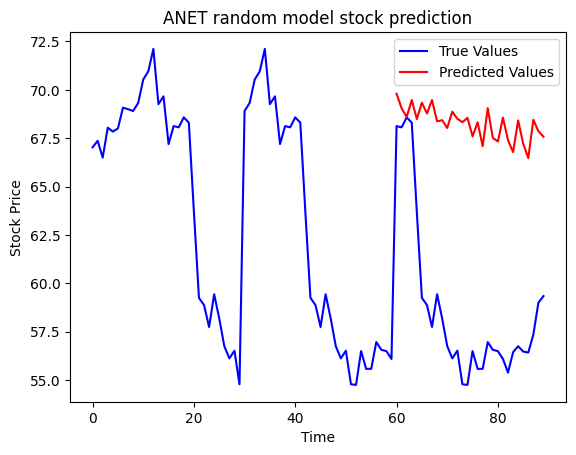

In [127]:
for i, x in enumerate(prev_y_test):
  prev_y_test[i] = x.cpu()
  print(x.shape)
all_y_test = np.concatenate(prev_y_test, axis=1)


import matplotlib.pyplot as plt

# Plot the true values in blue
plt.plot([i for i in range(90)], all_y_test[0], color='blue', label='True Values')

# Plot the predicted values in red
y_pred *= scaling_factor.to(device)
plt.plot([i for i in range(60, 90)], y_pred.cpu().numpy()[0], color='red', label='Predicted Values')

# Add axis labels and a legend
plt.title(f'{tickers[0]} random model stock prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()